##### Copyright 2018 The TensorFlow Authors.

In [116]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This module is based on the neural style transfer turoial in TensorFlow. The origianl code can be found [here](https://www.tensorflow.org/tutorials/generative/style_transfer). 

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

Here are some examples that I tried different styles on my own picture.

![](https://drive.google.com/uc?export=view&id=1nvSm_shkLGzpYqcAd_FPin00W8ElU6ae)

![](https://drive.google.com/uc?export=view&id=1u0a7dRVZPeZeVFjvA0W9BLePRIK8fPQk)

![](https://drive.google.com/uc?export=view&id=1qZCjDmXkM69VJ50VPiKGdX5PHIttufAN)


## Setup


### Import and configure modules

In [118]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
os.chdir('/content/drive/MyDrive/Deep Learning HW/homework 12')

In [119]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [120]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## 1. Understand your input images

Download your content image and style image to the 'day5/images' folder. There have been several style images in the folder. Please feel free to add your own style and content images to the folder.

**Exercise**: Please copy the path to your content image and the path to your style image to the variable `content_path` and `style_path`.

In [121]:
# start your code here
content_path = '/content/drive/MyDrive/Deep Learning HW/homework 12/neural style/Sunset-COE-04-mw-103019.jpg' # path to the content image
style_path = '/content/drive/MyDrive/Deep Learning HW/homework 12/neural style/Vincent-Van-Gogh-Cafe-Terrace-on-the-Place-du-Forum-Arles-at-Night-S.jpg' # path to the style image


Visualize your content image and style image to make sure they are what you want to transfer. 

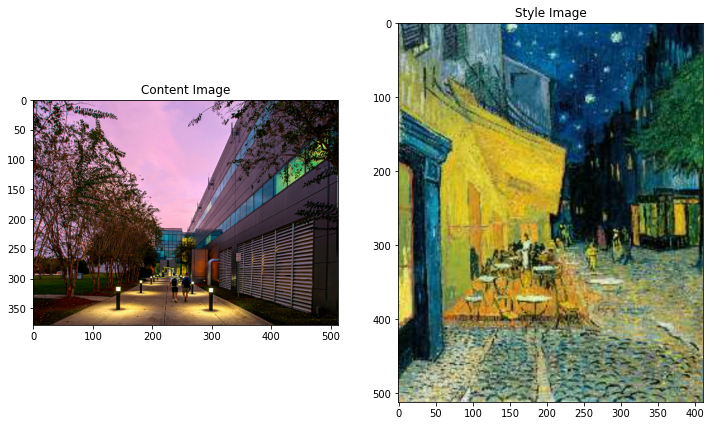

In [122]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

**Excercise**: Please print the shape of the two images using `image_name.shape`.



In [123]:
# start your code here
print('The shape of the content image: ', content_image.shape) 
print('The shape of the style image:', style_image.shape) 
# end your code here

The shape of the content image:  (1, 378, 512, 3)
The shape of the style image: (1, 512, 411, 3)


The RGB color of an image can be of value [0,255] or [0,1]. We want to make sure that the images are preprocessed and have RGB value between 0 and 1. 

In [124]:
# start your code here
print('The values of the content image:', content_image.numpy())
print('The values of the style image:', style_image.numpy())
# end your code here

The values of the content image: [[[[0.11624569 0.0956331  0.00089241]
   [0.37796193 0.19342844 0.20048091]
   [0.29070252 0.34975445 0.33151826]
   ...
   [0.1395185  0.10624291 0.08028498]
   [0.06209941 0.06473482 0.02755205]
   [0.0184519  0.02825622 0.00321752]]

  [[0.08474459 0.04303039 0.02368382]
   [0.06994413 0.04336047 0.        ]
   [0.18084393 0.20695382 0.12942003]
   ...
   [0.04459216 0.03255853 0.02060173]
   [0.01083708 0.00705107 0.00193477]
   [0.00355149 0.00364462 0.00443936]]

  [[0.13348393 0.07944561 0.00289725]
   [0.06384221 0.05033997 0.00547888]
   [0.3049952  0.13611943 0.06875864]
   ...
   [0.04259774 0.01527413 0.0124983 ]
   [0.00564779 0.00505515 0.        ]
   [0.01059024 0.00723141 0.00125714]]

  ...

  [[0.05252597 0.0123461  0.01336683]
   [0.06898134 0.00896918 0.0114575 ]
   [0.02553533 0.00913797 0.        ]
   ...
   [0.02452369 0.02131457 0.01654856]
   [0.01821504 0.01676683 0.00521277]
   [0.04736294 0.02965804 0.00693915]]

  [[0.169117

### 2. Understand the VGG19 model ###
The current VGG19 model presents top performance in the ImageNet Large Scale Visual Recognition Challenge ([ILSVRC](https://www.image-net.org/challenges/LSVRC/)). In this challenge, the participants need to 

I. Object localization for 1000 categories.

II. Object detection for 200 fully labeled categories.

III.Object detection from video for 30 fully labeled categories.

Now, let's load the VGG19 model with the pre-trained weights and play with it a little bit. 

We first load the VGG19 model with `tf.keras.applications.VGG19(include_top=True, weights='imagenet')`. Similar to VGGFace, we can load the VGG19 model with or without the top dense layers. With 'include_top=true', we will load the model with the top dense layers.

For more details about the VGG19 or VGG16 model, please check [here](https://keras.io/api/applications/vgg/#vgg19-function).

**Exercese:** Please print out the VGG19 model. How many neurons are there in the output layer? What does every output mean?

In [125]:
vgg_top = tf.keras.applications.VGG19(include_top=True, weights='imagenet') # vgg is the name of the CNN model

vgg_top.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Let's test the performance of the VGG19 model with the content image and the style image. 

1. *Preprocessing the images for the VGG19 model.* VGG16 and VGG19 needs to  convert the input images from RGB to BGR, then zero-center each color channel with respect to the ImageNet dataset, without scaling. We can use the function `tf.keras.applications.vgg19.preprocess_input` to do the pre-processing. 

2. *Resizing the image.* The default input size for VGG19 model is 224x224. We need to resize our current images using `tf.image.resize` before applying it into the model

3. *Applying the processed images to the model.* Finally, VGG19 model can take the processed images and predict its categories. 

4. *Printing out the top 5 categories.* The output of the VGG19 model will give the probability of 1000 categories. We will print out the top 5 categories.

We provide the code to predict the categories for the content image. 

In [126]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # preprocessing the content image
x = tf.image.resize(x, (224, 224)) # resizing the content image
prediction_probabilities_content = vgg_top(x) # applying the processed image to the vgg model

# print out the top 5 categories of the content image
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities_content.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('greenhouse', 0.28320047),
 ('palace', 0.07057093),
 ('picket_fence', 0.069485374),
 ('patio', 0.06442595),
 ('church', 0.060961504)]

**Exercise:** Please use the similar code to predict categories of the style image and print out the top 5 categories.

[('boathouse', 0.103530675),
 ('altar', 0.101624504),
 ('monastery', 0.0877538),
 ('church', 0.08476595),
 ('patio', 0.05194525)]

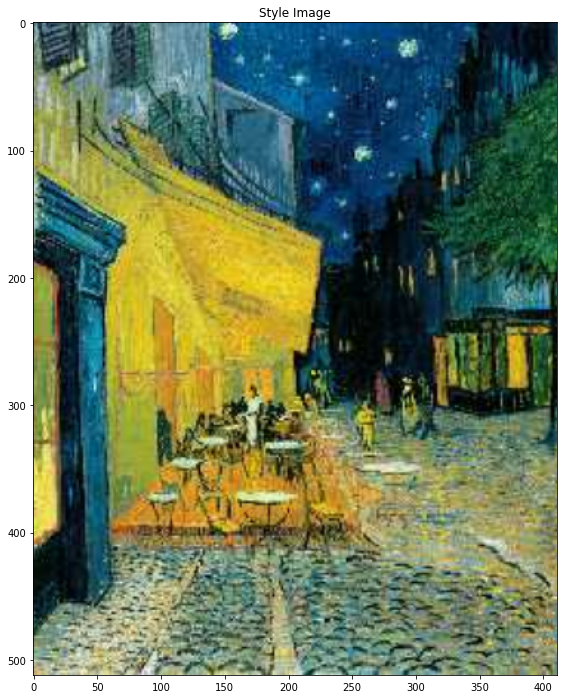

In [127]:
imshow(style_image, 'Style Image')
# start your code here
x = tf.keras.applications.vgg19.preprocess_input(style_image*255) # preprocessing the style image
x = tf.image.resize(x, (224, 224)) # resizing the style image
prediction_probabilities_style = vgg_top(x) # applying the processed image to the vgg model
# end your code here

# print out the top 5 categories of the content image
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities_style.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


We will use the intermediate layers to extract the content and style representations, and hence only need the bottom CNN layers using `tf.keras.applications.VGG19(include_top=False, weights='imagenet')`. 

**Exercise:** Can you tell the difference between the `vgg_top` model and the `vgg` model?

In [128]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 3. Build our own style transfer model based on VGG19 ##

Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Choose intermediate layers from the network to represent the style and content of the image:


In [129]:
# start your code here
content_layers = ['block5_conv4'] # you will need to choose the layers to represent the content feature. Layer name is the first column in the printed model in Sec. 2

style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv4', 
                'block4_conv4',
                'block5_conv4',] # you will need to choose the layers to represent the style feature. Layer name is the first column in the printed model in Sec. 2
# end your code here
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

### 3.1 Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [130]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [131]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv2
  shape:  (1, 512, 411, 64)
  min:  0.0
  max:  2704.7002
  mean:  152.00764

block2_conv2
  shape:  (1, 256, 205, 128)
  min:  0.0
  max:  5308.4185
  mean:  141.51765

block3_conv4
  shape:  (1, 128, 102, 256)
  min:  0.0
  max:  15504.079
  mean:  566.4558

block4_conv4
  shape:  (1, 64, 51, 512)
  min:  0.0
  max:  5047.3677
  mean:  39.165882

block5_conv4
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  159.53123
  mean:  0.78877693



### 3.2 Calculate style ###

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [132]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

#### 3.3 Extract style and content in one model


Build a model that returns the style and content tensors.

In [133]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def __call__(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [134]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  254.57364
    max:  248221.98
    mean:  17726.488

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.21840428
    max:  919843.3
    mean:  23891.049

   block3_conv4
    shape:  (1, 256, 256)
    min:  3054.2188
    max:  9734636.0
    mean:  400583.47

   block4_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  182993.58
    mean:  2018.8702

   block5_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  977.28253
    mean:  0.38957223

Contents:
   block5_conv4
    shape:  (1, 23, 32, 512)
    min:  0.0
    max:  220.75049
    mean:  0.4916361


### 4. Run gradient descent ###

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [135]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [136]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [137]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [138]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) # You can adjust the learning rate in the Adam optimizer to see whether there is any difference in the output. 

To optimize this, use a weighted combination of the two losses to get the total loss:

In [139]:
# start your code here
style_weight=1e+2  # You can increase the style_weight if you want stronger style in the generated picture
content_weight=1e+7# You can increase the content_weight if you want content style in the generated picture
# end your code here

In [140]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [141]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

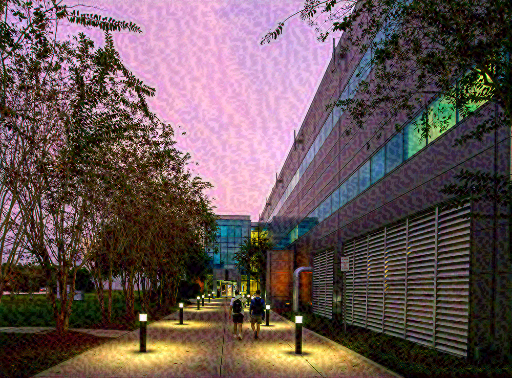

In [142]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

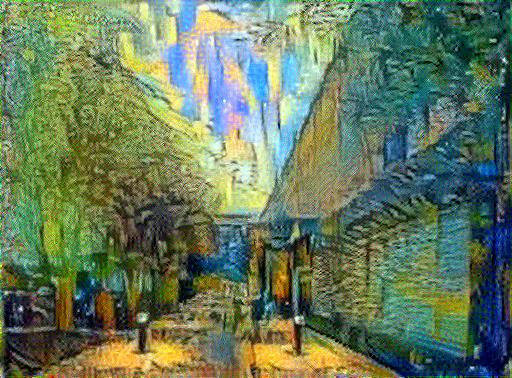

Train step: 704
.................................

KeyboardInterrupt: ignored

In [143]:
import time
start = time.time()

epochs = 30 # If you want to train your image longer, you can try a larger number
steps_per_epoch = 64

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

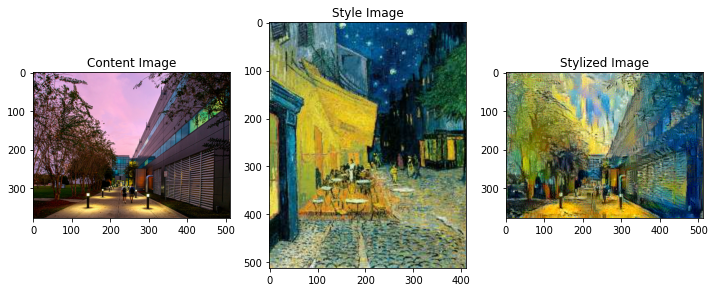

In [115]:
# start your code here
file_name = 'stylized-image-7.png' # The image name you saved in Google Drive
# end your code here
tensor_to_image(image).save(file_name)

plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
stylized_image=load_img(file_name)
imshow(stylized_image, 'Stylized Image')